# BERT 다중 클래스 분류.

Bert(Bidirectional Encoder Representations from Transformers)는 

구글이 2018년에 10월에 발표한 사전학습 모델입니다.

BERT는 [Attention is all You need]논문에서 제시한 트렌스포가 다층으로 인코더를 구성합니다.

BERT 발표 이후 많은 파생 모델들이 발표되었습니다.

이후 09장에서는 파이토치로 작성된 BERT를 소규모 데이터에 재학습을 시켜 다중 클래스 분류 작업을 수행해 봅니다.

다중 클래스 분류 작업을 BERT로 처리하기 위한 모듈을 설치합니다.

그리고 bert-base-cased를 토크나이저 및 모델로 불러옵니다.

여기에서 cased는 입력 텍스트를 대문자와 소문자 그대로 식별한다는 뜻입니다.

이에 반해 uncased는 입력 텍스트를 모두 소문자로 전환하여 인식한다는 뜻 입니다.

In [1]:
# 로드드
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels=3)

/mnt/d/workspace/colab_try/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
# 전처리
import torch

# 데이터 세트 준비!
text_inputs = ["I like apple", "I go to school", "I dislike mosquito", "I felt very said", "I feel so good"]
labels = ["positive", "neutral", "negative"]
labels_dict = { 
    0: 'positive', 1: 'negative', 2: 'negative'
}

answer = torch.tensor([0, 1, 2, 2, 0])

In [3]:
# 학습습
from transformers import AdamW
from tqdm import tqdm
optimizer = AdamW(model.parameters(), lr=1e-5)

model.train()

epochs = 50
losses = []

# 파인튜닝 과정!!!
message = tqdm(range(epochs), desc='Training')
for epoch in tqdm(range(epochs)):
    # 기울기를 초기화.
    optimizer.zero_grad()
    inputs = tokenizer.batch_encode_plus(text_inputs, return_tensors='pt', padding=True, truncation=True) # 이 함수의 역할을 여러 문장을 한번에 토큰화 하고 padding Trunation 자동처리하며 Attention Mask 까지 자동화 처리한다.

    outputs = model(**inputs, labels=answer)

    # 로짓 추출
    logits = outputs.logits

    # 손실 추출
    loss = outputs.loss

    # 오차 역전파
    loss.backward()

    # 가중치(weight) 업데이트
    optimizer.step()

    # 손실을 빈 컨테이너 losses에 순서대로 저장.
    losses.append(loss)

    # 에포크 및 손실값 출력
    # 에포크는 0부터 시작하므로 1을 더해서 에포크 회수를 하나씩 늘려가며 표시.
    message.set_description(f"epoch: {epoch+1}, loss: {loss}")


/mnt/d/workspace/colab_try/.venv/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training:   0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:18<00:00,  2.73it/s]      | 0/50 [00:18<?, ?it/s]


In [4]:
# 추론론
model.eval()
with torch.no_grad():
    for article in text_inputs:
        ouput_tokenizer = tokenizer.encode(article, return_tensors='pt', padding=True, truncation=True)
        ouput_model = model(ouput_tokenizer)
        logits = ouput_model.logits
        print(f"{labels_dict[logits.argmax(-1).item()]}:{article}")

positive:I like apple
negative:I go to school
negative:I dislike mosquito
negative:I felt very said
positive:I feel so good


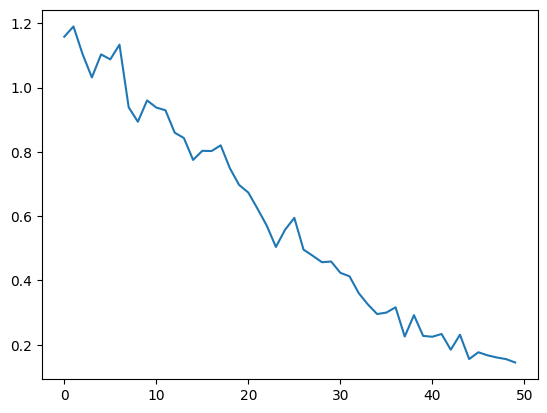

In [5]:
# 파인튜닝 BERT 모델 학습 과정 시각화
# 문제 046의 손실 수렴과정을 matplotlib를 통해 가시화해라.
import matplotlib.pyplot as plt
new_losses = [i.item() for i in losses]

plt.plot(new_losses)

In [6]:
# 048 학습 후 추론.
model.eval()
# 모델 예측을 담을 preds라는 빈 컨테이너 리스트를 생성
preds = []

with torch.no_grad():
    for article in text_inputs:
        ouput_tokenizer = tokenizer.encode(article, return_tensors='pt', padding=True, truncation=True)
        ouput_model = model(ouput_tokenizer)
        logits = ouput_model.logits
        pred = logits.argmax(-1).item()
        preds.append(logits.argmax(-1).item())
        print(f"{labels[pred]}:{article}")

positive:I like apple
neutral:I go to school
negative:I dislike mosquito
negative:I felt very said
positive:I feel so good


In [10]:
# 분류 정확도.

# 문제 048의 추련결과의 정확도를 게산하시오
import torch
preds = torch.tensor(preds)

print(f"Accuracy:{100 * sum(answer.detach().clone()==preds)/len(answer.detach().clone())}%")

Accuracy:100.0%


/tmp/ipykernel_12740/3635329565.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = torch.tensor(preds)
